In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

/home/obj_api_3/models/research/object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/root/.virtualenvs/gpu-py3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/root/.virtualenvs/gpu-py3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/root/.virtualenvs/gpu-py3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.st

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
root_folder = '/home/JulioCesar/calle100_elevator'

# model to use
MODEL_NAME = os.path.join(root_folder, 'init_model', 'model-3111')

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = os.path.join(MODEL_NAME, 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(root_folder, 'elevator_label_map.pbtxt')

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [7]:
print(category_index)
dict_ref = {}
for idx in category_index.keys():
    dict_ref[category_index[idx]['id']] = category_index[idx]['name']
print(dict_ref)

{1: {'name': 'abierta', 'id': 1}, 2: {'name': 'cerrada', 'id': 2}}
{1: 'abierta', 2: 'cerrada'}


## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
PATH_TO_TEST_IMAGES_DIR = os.path.join(root_folder, 'Images')
test_imgs_list = os.listdir(PATH_TO_TEST_IMAGES_DIR)
TEST_IMAGE_PATHS = []
for img in test_imgs_list:
    TEST_IMAGE_PATHS.append(os.path.join(PATH_TO_TEST_IMAGES_DIR, img))

IMAGE_SIZE = (24, 16)

In [10]:
target_folder = os.path.join(root_folder, 'created_annotations')
if not os.path.exists(target_folder):
    os.mkdir(target_folder)

In [11]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [12]:
from lxml import etree
import xml.etree.ElementTree as ET

0/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_95.jpg
1/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_635.jpg
2/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_402.jpg
3/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_595.jpg
4/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_526.jpg
5/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_99.jpg
6/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_43.jpg
7/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_579.jpg
8/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_181.jpg
9/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_120.jpg
10/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_418.jpg
11/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IM

96/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_336.jpg
97/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_189.jpg
98/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_479.jpg
99/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_573.jpg
100/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_11.jpg
101/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_607.jpg
102/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_114.jpg
103/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_123.jpg
104/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_85.jpg
105/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_218.jpg
106/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_30.jpg
107/770 Image path: /home/JulioCesar/calle100_elev

191/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_59.jpg
192/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_283.jpg
193/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_543.jpg
194/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_357.jpg
195/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_657.jpg
196/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_462.jpg
197/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_685.jpg
198/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_223.jpg
199/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_401.jpg
200/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_625.jpg
201/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_669.jpg
202/770 Image path: /home/JulioCesar/calle10

286/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_636.jpg
287/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_666.jpg
288/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_439.jpg
289/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_731.jpg
290/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_6.jpg
291/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_510.jpg
292/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_135.jpg
293/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_565.jpg
294/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_22.jpg
295/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_614.jpg
296/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_558.jpg
297/770 Image path: /home/JulioCesar/calle100_

381/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_471.jpg
382/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_475.jpg
383/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_15.jpg
384/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_372.jpg
385/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_396.jpg
386/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_358.jpg
387/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_498.jpg
388/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_294.jpg
389/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_297.jpg
390/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_20.jpg
391/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_496.jpg
392/770 Image path: /home/JulioCesar/calle100

476/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_334.jpg
477/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_497.jpg
478/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_601.jpg
479/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_600.jpg
480/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_642.jpg
481/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_673.jpg
482/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_570.jpg
483/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_298.jpg
484/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_244.jpg
485/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_349.jpg
486/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_488.jpg
487/770 Image path: /home/JulioCesar/calle1

571/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_69.jpg
572/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_755.jpg
573/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_162.jpg
574/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_378.jpg
575/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_440.jpg
576/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_747.jpg
577/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_590.jpg
578/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_487.jpg
579/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_348.jpg
580/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_628.jpg
581/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_350.jpg
582/770 Image path: /home/JulioCesar/calle10

666/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_437.jpg
667/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_265.jpg
668/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_767.jpg
669/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_140.jpg
670/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_286.jpg
671/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_417.jpg
672/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_679.jpg
673/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_725.jpg
674/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_171.jpg
675/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_356.jpg
676/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_436.jpg
677/770 Image path: /home/JulioCesar/calle1

761/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_700.jpg
762/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_457.jpg
763/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_737.jpg
764/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_156.jpg
765/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_499.jpg
766/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_309.jpg
767/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_268.jpg
768/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_757.jpg
769/770 Image path: /home/JulioCesar/calle100_elevator/Images/aux_IMG_fisheye1_226.jpg


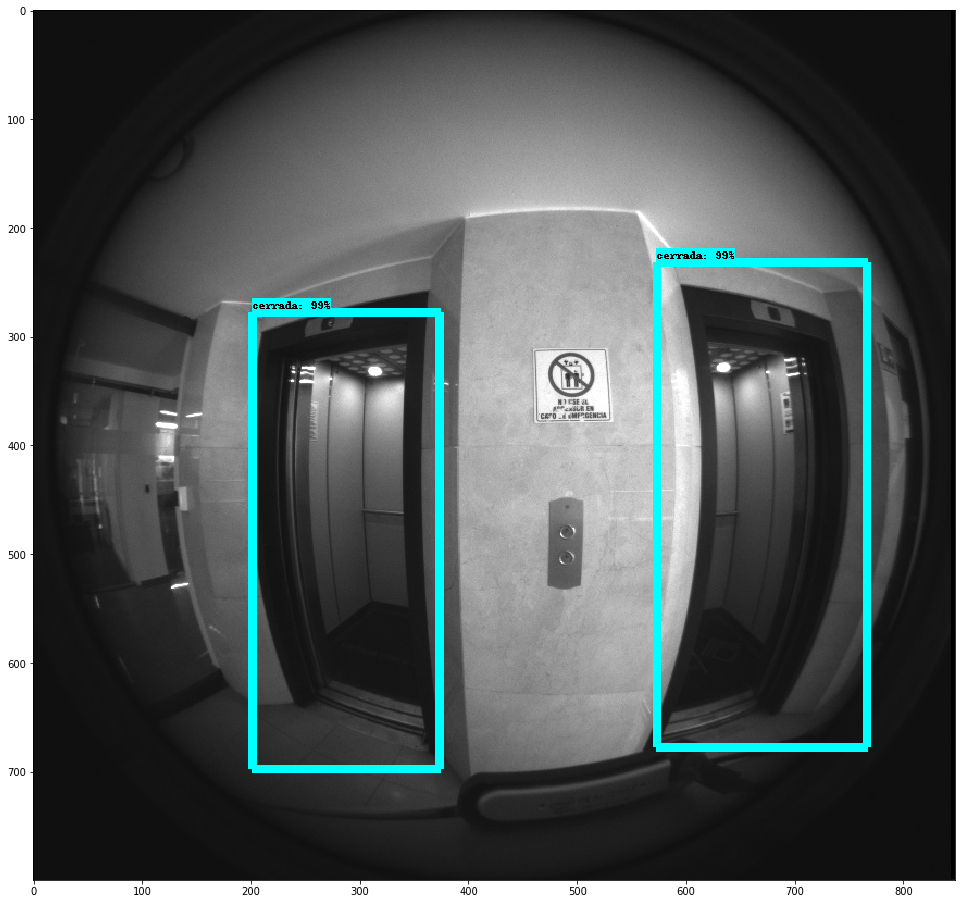

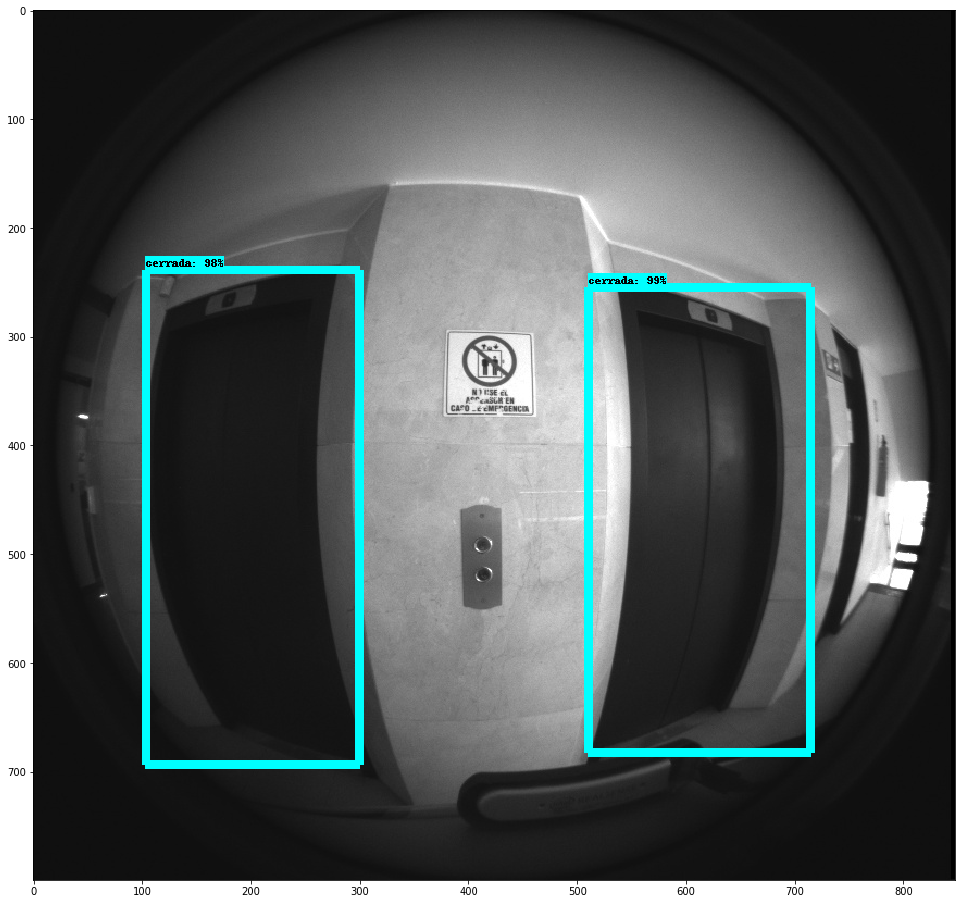

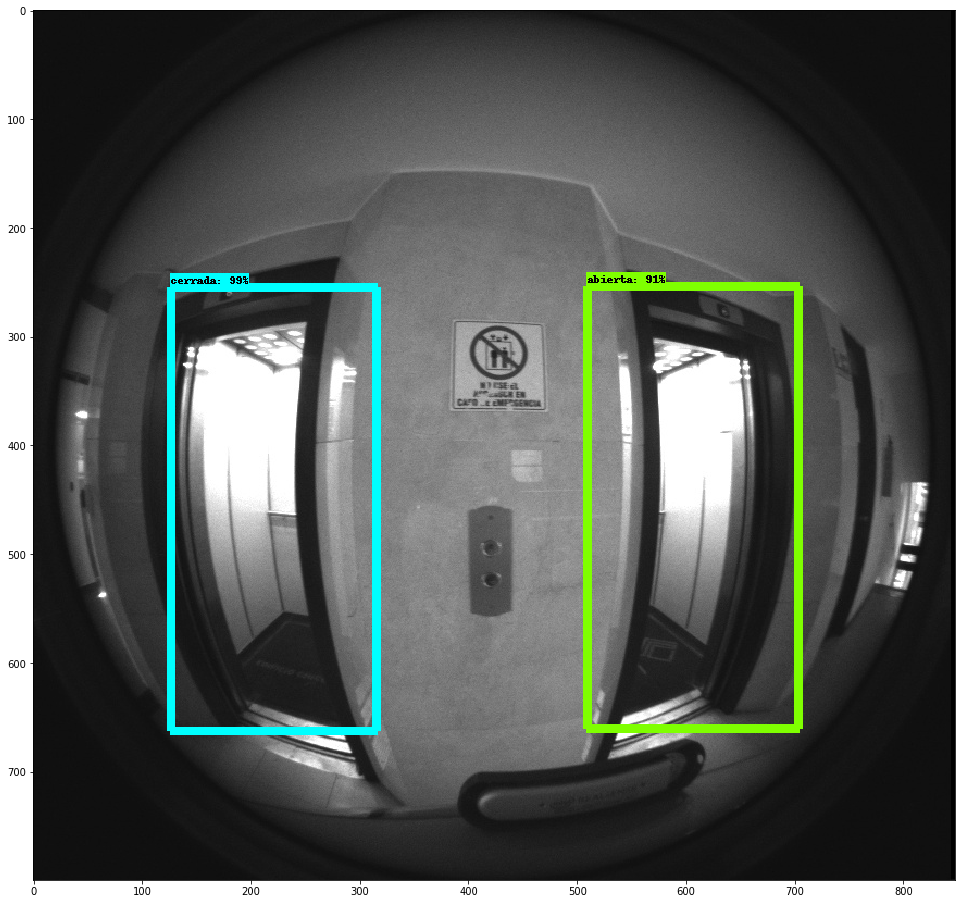

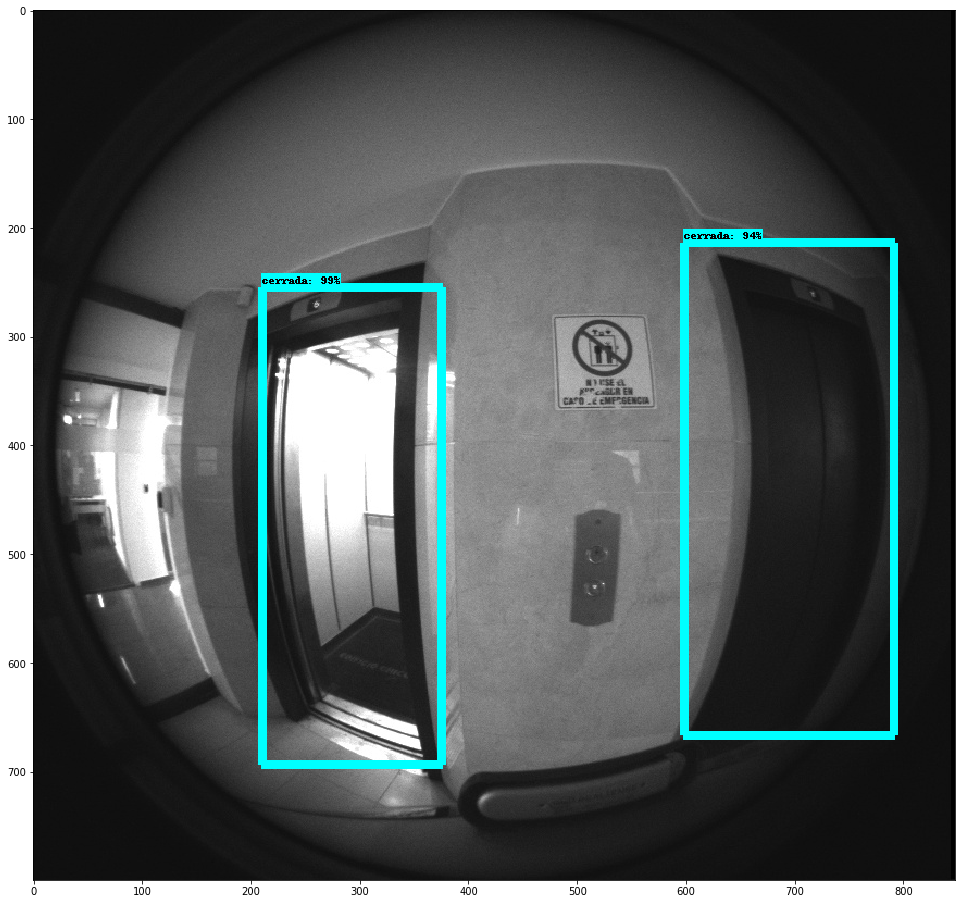

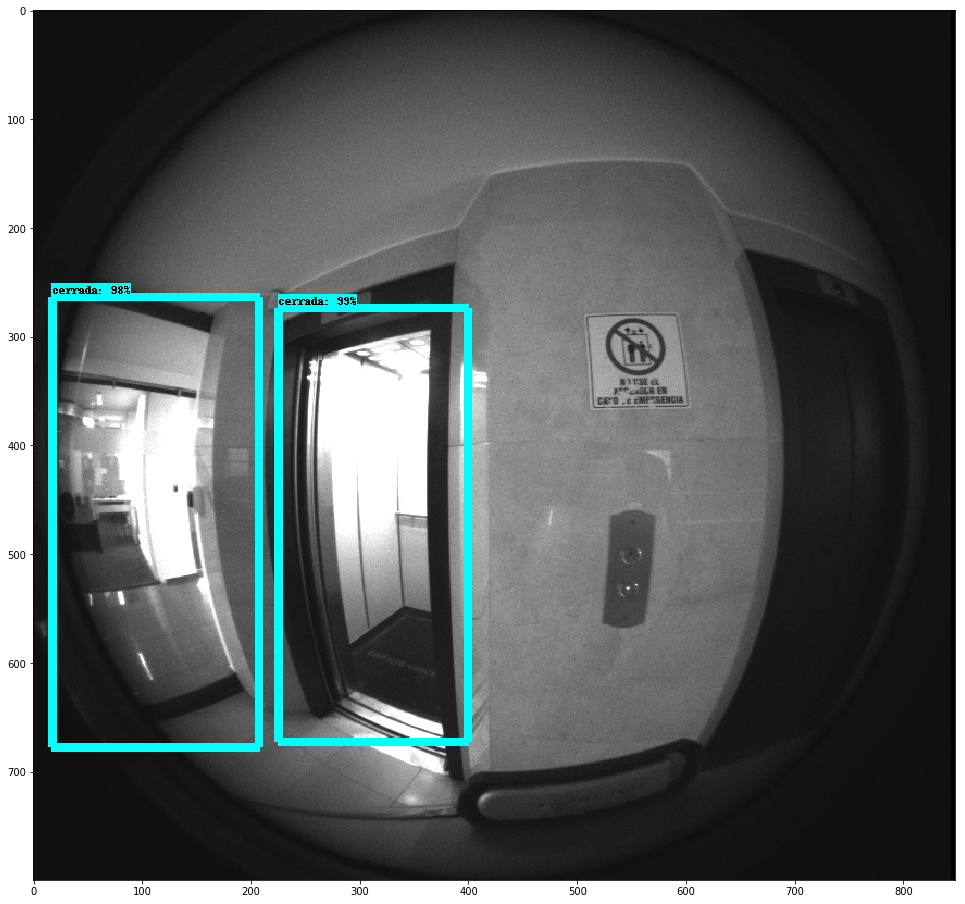

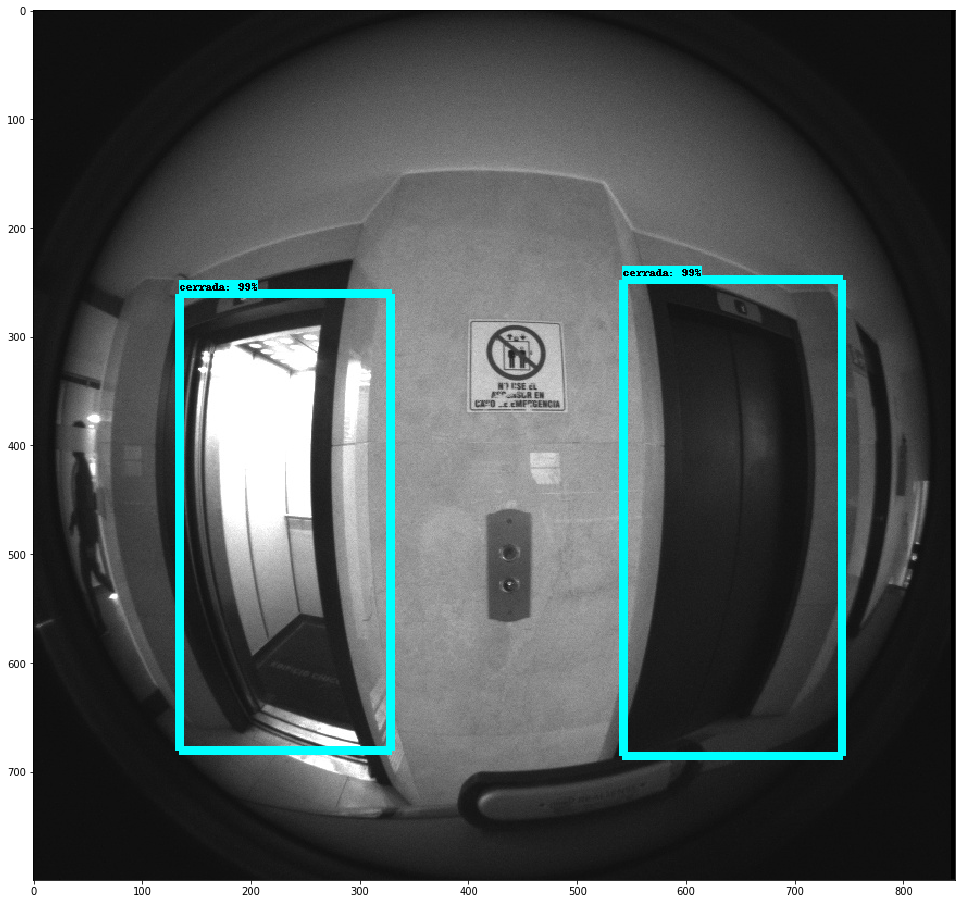

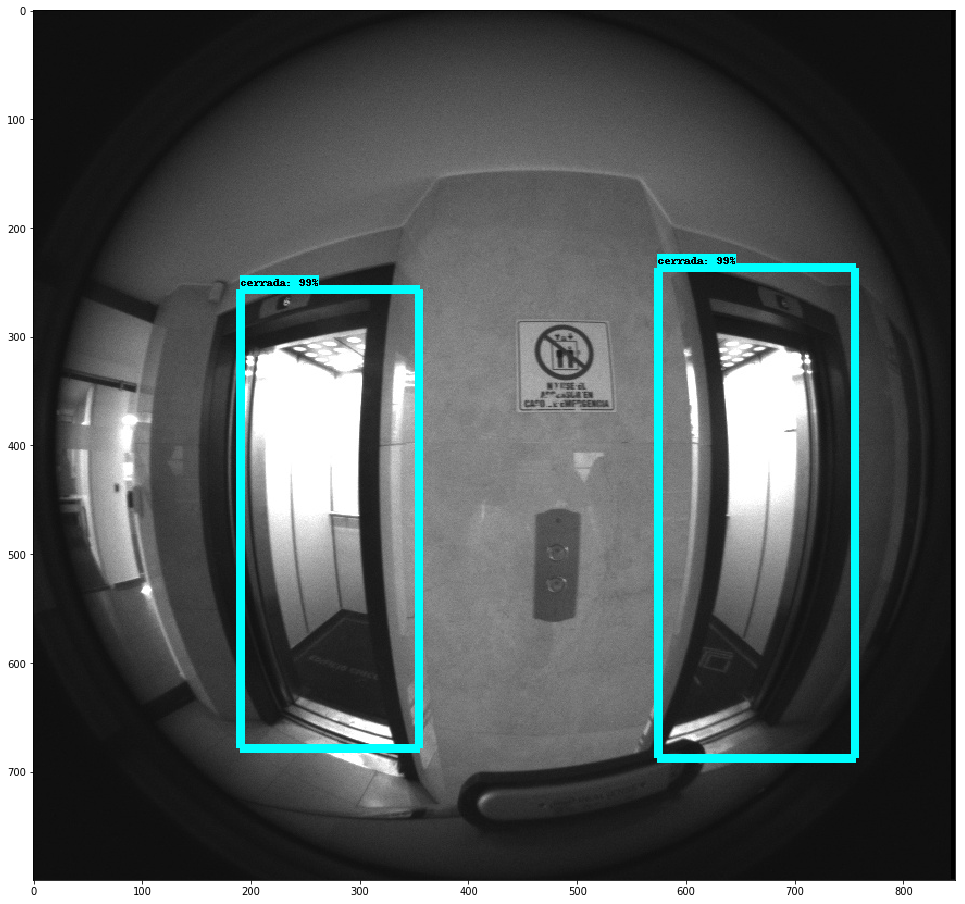

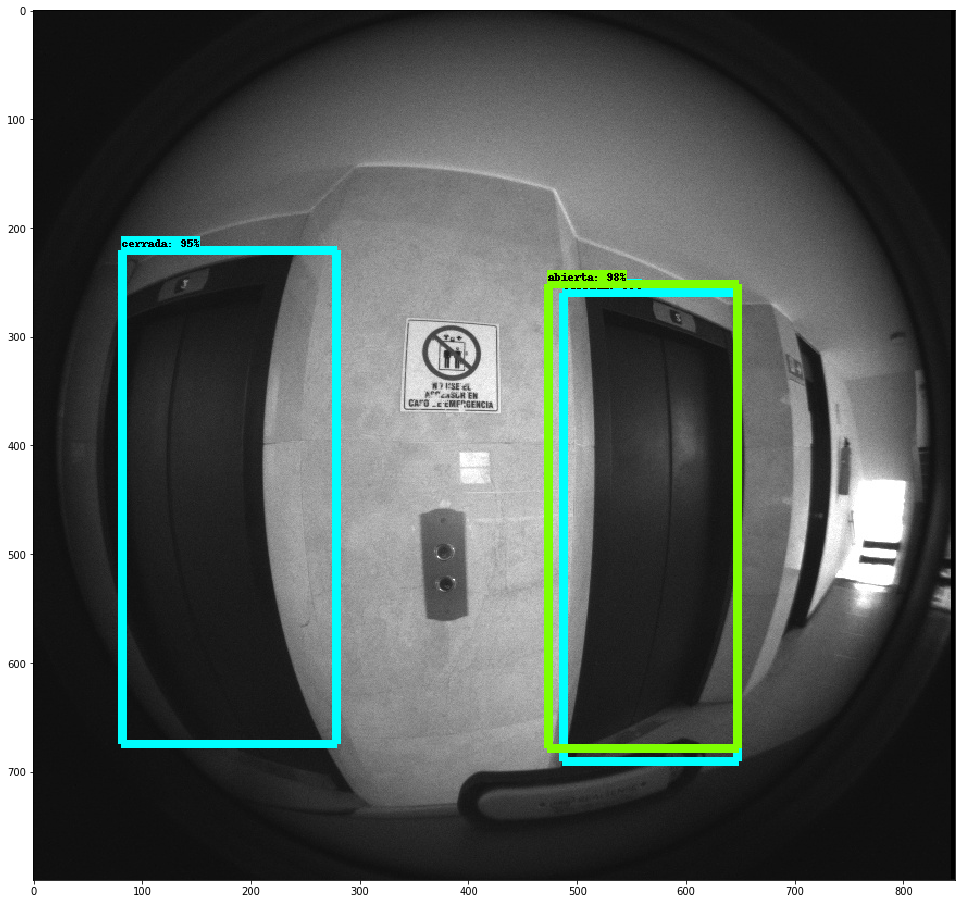

In [13]:
for idx, image_path in enumerate(TEST_IMAGE_PATHS):
    pass
    print('{}/{} '.format(idx, len(TEST_IMAGE_PATHS)) + 'Image path: ' + image_path)
    image = Image.open(image_path)
    width, height = image.size
    channels = 3
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    scores = output_dict['detection_scores']
    detected_objects = output_dict['detection_classes']
    
    img_name = image_path.split('/')[-1].split('.')[0]
    
    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "folder").text = "Images"
    ET.SubElement(annotation, "filename").text = img_name
    ET.SubElement(annotation, "path").text = image_path

    source = ET.SubElement(annotation, "source")
    ET.SubElement(source, "database").text = "Unknown"

    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = str(channels)
    ET.SubElement(annotation, "segmented").text = "0"
    
    threshold = 0.9
    for i in range(len(scores)):
        if scores[i] >= threshold:
            name_object = dict_ref[detected_objects[i]]
            [ymin, xmin, ymax, xmax] = output_dict['detection_boxes'][i]
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            
            object_annotation = ET.SubElement(annotation, "object")
            ET.SubElement(object_annotation, "name").text = name_object
            ET.SubElement(object_annotation, "pose").text = "Unspecified"
            ET.SubElement(object_annotation, "truncated").text = "0"
            ET.SubElement(object_annotation, "difficult").text = "0"
            bndbox = ET.SubElement(object_annotation, "bndbox")
            ET.SubElement(bndbox, "xmin").text = str(xmin)
            ET.SubElement(bndbox, "ymin").text = str(ymin)
            ET.SubElement(bndbox, "xmax").text = str(xmax)
            ET.SubElement(bndbox, "ymax").text = str(ymax)
    
    tree = ET.ElementTree(annotation)
    root = tree.getroot()
    xmlstr = ET.tostring(root, encoding='utf8', method='xml')

    tree.write(os.path.join(target_folder, img_name + '.xml'))
  
    # Visualization of the results of a detection
    if idx % 100 == 0:
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            max_boxes_to_draw=3,
            min_score_thresh=threshold,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            line_thickness=8)

        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)